In [2]:
import requests
import asyncio
from systemlink.clients.nitdmreader.api.metadata_api import MetadataApi
from systemlink.clients.nitdmreader.models.file_list import FileList

metadata_api = MetadataApi()
import scrapbook as sb

import matplotlib.pyplot as plt
import numpy as np

from systemlink.clients.nitdmreader import *
data_api = DataApi()

In [3]:
# --- Metadata helper methods ---

def get_groups(file_info):
    if not hasattr(file_info, '__getitem__'):
        return [g for g in file_info.groups]
    else:
        return [g for g in file_info["groups"]]

def get_group_names(file_info):
    if not hasattr(file_info, '__getitem__'):
        return [g.name for g in get_groups(file_info)]
    else:
        return [g["name"] for g in get_groups(file_info)]

def get_channels(group):
    if not hasattr(group, '__getitem__'):
        return [c for c in group.channels]
    else:
        return [c for c in group["channels"]]

def get_channel_names(group):
    if not hasattr(group, '__getitem__'):
        return [c.name for c in get_channels(group)]
    else:
        return [c["name"] for c in get_channels(group)]

def get_property(element, property_name):
    if not hasattr(element, '__getitem__'):
        return next((e.value for e in element.properties.properties if e.name == property_name), None)
    else:
        return next((e["value"] for e in element["properties"]["properties"] if e["name"] == property_name), None)

In [4]:
# use data links to read data
data_links = ni_analysis_automation["data_links"]
file_ids = [d["fileId"] for d in data_links]
file_infos = await metadata_api.get_multiple_file_info(FileList(file_ids))
file_info = file_infos[0]

test_file_name = get_property(file_info, "name")
program_name = get_property(file_info, "Test~Procedure") or get_property(file_info, file_name_prop)
#display(program_name)
group_names = get_group_names(file_info)
#display(group_names)

stati = []
channels = []
formatted_properties = []

grp_idx = 0
for group in get_groups(file_info):
    max_values_of_group = []    
    min_values_of_group = []    
    mean_values_of_group = []    
    channel_names = get_channel_names(group)
    #display("Channel Names of Group ["+ group.name +"]" + str(channel_names))

    channels = get_channels(group)
    for channel in channels:
        minimum = float(get_property(channel, "minimum") or "NaN")
        maximum = float(get_property(channel, "maximum") or "NaN")
        mean_values_of_group.append((minimum + maximum) / 2)
        max_values_of_group.append(maximum)
        min_values_of_group.append(minimum)

        
    # --- Calculate statistic values from meta data ---
    abs_min, abs_max, abs_mean = max(max_values_of_group), min(min_values_of_group), sum(mean_values_of_group) / float(len(mean_values_of_group))
    formatted_properties.append("Absolute Maximum: "+str(round(abs_max,3))+" A,Absolute Minimum: "+str(round(abs_min,3))+" A,Mean Value: "+str(round(abs_mean,3))+" A") 

#display(channels[0])


In [5]:
# --- The Analysis Automation Procedure Package parameter cell correspnding to the ANP parameter definition. 
#     (see: cell "property inspector" => area: Advanced Tools => cell metadata)

grp_1 = 22.3
grp_2 = 23.8

In [6]:
# --- The  Analysis Automation Procedure Package parameter parameter set is avaible from the cell below the parameter cell itself 

# put the parameter to the info box of the plot. 
formatted_properties[0] +=",Parameter: " + str(grp_1)
formatted_properties[1] +=",Parameter: " + str(grp_2)

In [7]:
# -- Get bulk data from DataLink
bulk_data = []
file_id = data_links[0]['fileId']

for group in get_groups(file_info):
    channel_specifier = []
    chn_specs = []
    group_name = group.name 
    channels = get_channels(group)
    for channel in channels:
        channel_name = channel.name 
        channel_specifier = OneChannelSpecifier(file_id=file_id, group_name=group_name, channel_name=channel_name)
        #display(channel_specifier)
        chn_specs.append(channel_specifier)

    xy_chns = ChannelSpecificationsXyChannels(y_channels=chn_specs)
    channel_specs = ChannelSpecifications(xy_channels=[xy_chns])
    query = QueryDataSpecifier(channel_specs)
    #display(query)
    data = await data_api.query_data(query)
    
    # get numeric y data
    y_channels = data.data[0].y
    #display(len(y_channels))
    values = list(map(lambda c: c.numeric_data, y_channels))
    #display(len(values[0]))
    #display(values)
    bulk_data.append(values)


In [8]:
# --- Helper fuction and const to plot the data ---
CurrFontsize = 18
AxisLableFontSize = CurrFontsize - 5

def PlotArea(subplot, BulkData, ChnMetaData, FormattedProperties):
    """ Plot a sub print area of a figuer 
     :param subplot:            Object of the plot print area 
     :param BulkData:           Channel bulk data to print
     :param MetaData:           Channel meta data (name, properties, ...)
     :param FormattedProperties: Stirng with comma separated parts as contend of the info box area
                                e.g.: "Absolute Maximum: 12.6 A,Absolute Minimum: -22.3 A"
    """
    # Place a text box below the legend
    subplot.text(1.05, 0.0, FormattedProperties.replace(",", "\n"),
                transform=subplot.transAxes, ha="left", va="bottom")
    subplot.grid(True)
    subplot.set_xlabel('Time [s]', fontsize=AxisLableFontSize)
    
    unit = get_property(ChnMetaData[0], "unit_string")
    subplot.set_ylabel('Amplitudes ['+unit+']', fontsize=AxisLableFontSize)
    i = 0
    for channel in ChnMetaData:
        subplot.plot(BulkData[i], label=channel.name)      # Lable => name of the curve = channel 
        i = i + 1

        
    # Place a legend to the right of this subplot.
    subplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=AxisLableFontSize)


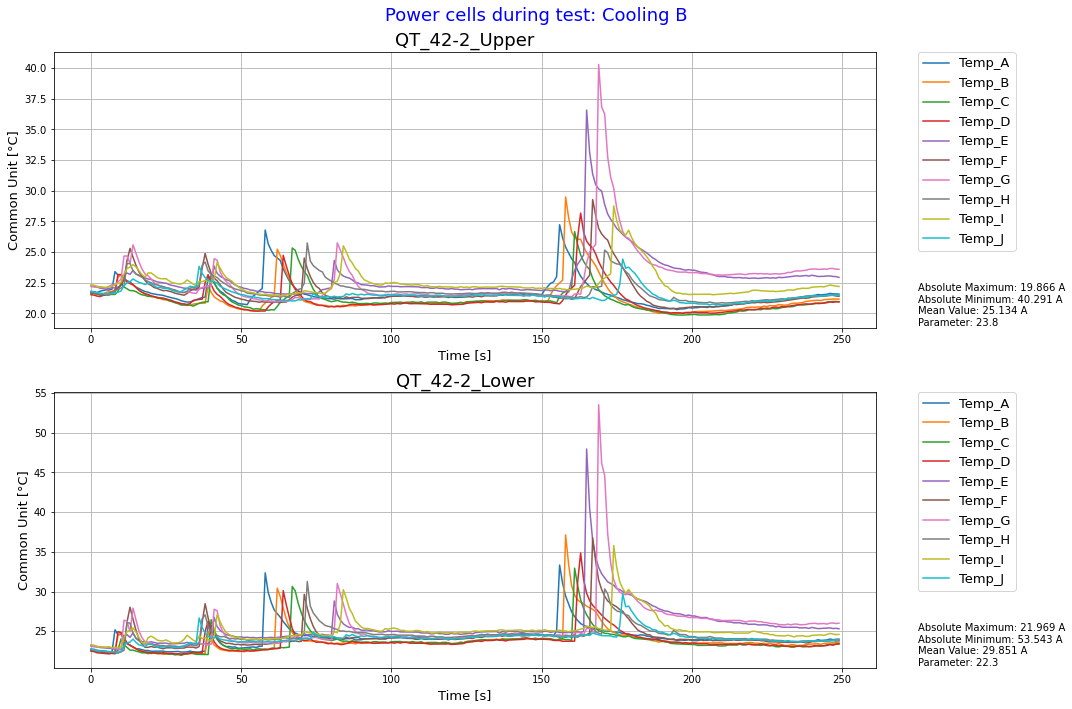

In [9]:
#--- Create a plot and print the data ---
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
fig.suptitle ('Temperature Monitoring File: '+ test_file_name + '     Test program: ' + program_name, fontsize=CurrFontsize, color='blue')

ax1.set_title(group_names[1], fontsize=CurrFontsize)
PlotArea(ax1, bulk_data[1],  channels, formatted_properties[1])
ax2.set_title(group_names[0], fontsize=CurrFontsize)
PlotArea(ax2, bulk_data[0], channels, formatted_properties[0])

plt.tight_layout()
plt.show()